## Website Landing Page EDA, Statistical Analysis and Conversion Prediction

### Description of data  
Source Dataset: https://github.com/jainds/eda-for-conversion-rate-dataset/tree/master  

- "conversion_data" - information about signed-in users during one session. Each row is a user session.
- *country* : user country based on the IP address
- *age* : user age. Self-reported at sign-in step
- *new_user* : whether the user created the account during this session or had already an account and simply came back to the site
- *source* : marketing channel source
    - *Ads*: came to the site by clicking on an advertisement
    - *Seo*: came to the site by clicking on search results
    - *Direct*: came to the site by directly typing the URL on the browser
- *total_pages_visited*: number of total pages visited during the session (proxy for time spent on site and engagement during the session).
- *converted*: this is our label. 1 means they converted within the session, 0 means they left without buying anything.

### Objective
- Conduct an Exploratory Data Analysis (Data cleaning & prep, Uni/Bivariate Analysis, Conversion Rate Analysis)
- Statistical Testing to assess variables impacting Conversion Rate, Relationships among Variables 
- A/B Testing to assess impact of change in Landing Page (using artifically generated experiment vs. control group data)
- Development of an ML Classification model to predict Conversion of User, achieving at least 85% F1 Score.


### Initiation

In [1]:
# Import libraries

# Basic Data Imports
import numpy as np
import pandas as pd
import datetime as dt 

# Imports for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Imports for stats
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import binom, chi2_contingency, levene, ttest_ind, mannwhitneyu, anderson

# Imports for Classification modeling
import sklearn.metrics as metrics 
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from xgboost import plot_importance


In [2]:
# Import dataset

df_original= pd.read_csv('data/conversion_data.csv')
df_original.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [3]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


- Total 316,200 records, none of the columns have null values.
- No changes needed in data type.

In [4]:
df_original.describe(include= 'all')

,country,age,new_user,source,total_pages_visited,converted
count,316200,316200.000000,316200.000000,316200,316200.000000,316200.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,178092,NaN,NaN,155040,NaN,NaN
mean,NaN,30.569858,0.685465,NaN,4.872966,0.032258
std,NaN,8.271802,0.464331,NaN,3.341104,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


Initial Observations:
- Our dataset is derived from 4 countries, with most of the data being from US (more than 50%).
- Average age of visitors is ~ 31 years. Maximum age is 123 years, which looks like an outlier. Will check for outlying values.
- *new_user* being 1 implies they created an account when they visited the website in that instance. Average value of 0.68 indicates generally we might have more new users than old users.
- We have 3 channels identified as source (already defined in data description). ~50% of the visitors are coming from search results, and are in majority.
- Average page visits by users = 4.87. Maximum page visits by a user in a session is 29.
- *converted* would imply sale/conversion in that particular record/session. Average value of 0.0322 implies about 3.22% aggregate conversion rate. 


In [5]:
# Convert String columns as Categorical
cols = ['country', 'source','new_user']
df_original[cols] = df_original[cols].astype('category')

df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   country              316200 non-null  category
 1   age                  316200 non-null  int64   
 2   new_user             316200 non-null  category
 3   source               316200 non-null  category
 4   total_pages_visited  316200 non-null  int64   
 5   converted            316200 non-null  int64   
dtypes: category(3), int64(3)
memory usage: 8.1 MB


### Exploratory Data Analysis (EDA)
We'll follow the workflow below:
- Data Cleaning & Preparation, Check for missing values, duplicates and outliers.
- *Univariate Analysis*: 
    - Examine distributions of numerical variables (histograms for age, pages visited, etc.).
    - Review frequency counts for categorical variables (country, acquisition channel).
- *Bivariate Analysis*:
    - %age conversion by Country
    - Distribution of age comparison (converted vs. non-converted)
    - Distribution of new user vs. conversion
    - Distribution of page visits comparison (converted vs. non-converted)
- *Deriving Conversion Rate*:
    - Calculate Agg. Conversion Rate (No. of Conversions/Total Sessions)
    - *Segmented rates*: conversion rates by category (e.g., by country, device type).

#### Data Cleaning

In [6]:
# Already checked in DF info that we don't have null values.
# Checking for duplicates

df_original.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


As the variables contain information about the demographic, marketing channel and general stats, there are likely to be duplications, considering we don't have any Personal Information to differentiate user session by any identity or specific location/time etc.  

Hence in this case, we will not be removing any duplicate records. We have already reviewed under the dataframe info that none of the columns have missing values.

In [7]:
df_original.isna().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

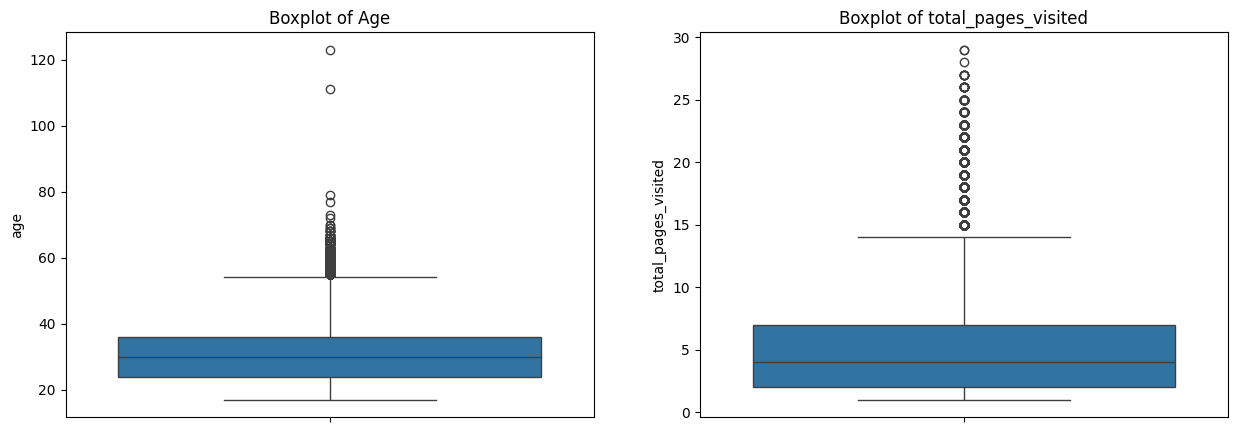

In [8]:
# Plotting boxplot to assess outliers in continuous variables age and total_pages_visited 
fig, axes = plt.subplots(1,2, figsize= (15,5))
ax1= sns.boxplot(df_original['age'],ax= axes[0])
ax1.set_title('Boxplot of Age')

ax2= sns.boxplot(df_original['total_pages_visited'],ax= axes[1])
ax2.set_title('Boxplot of total_pages_visited')

plt.show()

- 'Age' has quite a few extreme outliers. We also have values greater than 100, which we'll look into. Outliers might need to be dealt with for some modeling uses.
- 'total_pages_visited' is less skewed and there are some outlying values.
- We'll consider necessary action based on future needs.

In [9]:
df_original[df_original['age'] >100]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


In [10]:
df_original.sort_values(by= ['age'], ascending= False).head()

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1
265167,US,79,1,Direct,1,0
192644,US,77,0,Direct,4,0
154217,US,73,1,Seo,5,0


There are 2 sessions, wherein the visitor age is above 100, which seems an erroneous value. As these are just 2 session records, we'll leave them as it is, given it wouldn't impact much.

In [11]:
# Creating a derived DF with renamed columns for simplicity
df_edit= df_original.rename(columns= {'total_pages_visited':'page_visits', 'source':'channel'})
df_edit.head()

,country,age,new_user,channel,page_visits,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


#### Univariate Analysis 

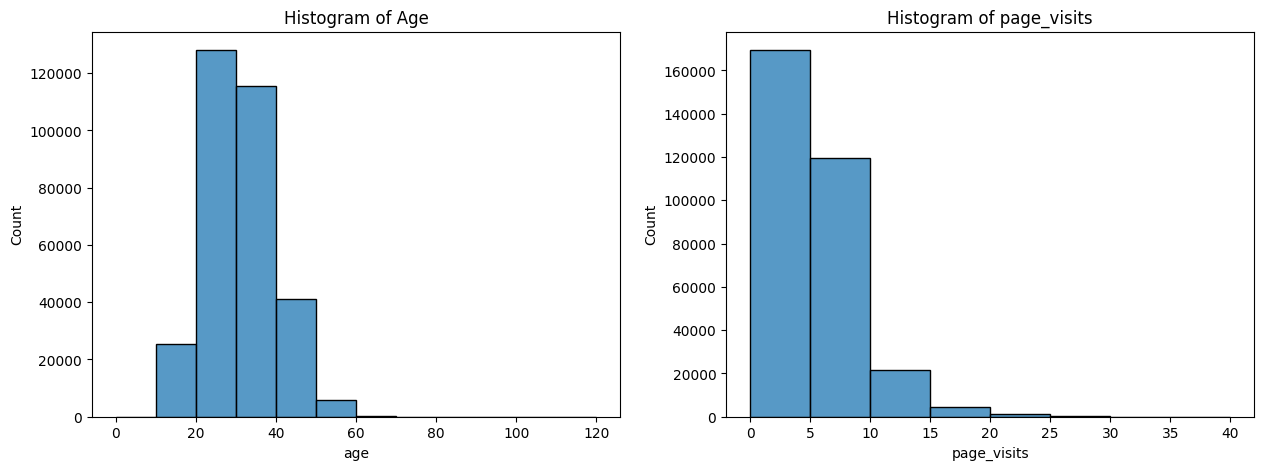

In [12]:
# Plotting histogram to review distribution of discrete variables
fig, axes = plt.subplots(1,2, figsize= (15,5))
ax1= sns.histplot(df_edit['age'], binwidth= 10, binrange= (0,120), ax= axes[0])
ax1.set_title('Histogram of Age')

ax2= sns.histplot(df_edit['page_visits'], binwidth= 5, binrange= (0,40), ax= axes[1])
ax2.set_title('Histogram of page_visits')

plt.show()

In [13]:
# Summary Statistics:
print('Five Number Summary - Age:-')
print('Minimum age:', df_edit['age'].min())
print('Lower Quartile:', df_edit['age'].quantile(0.25))
print('Median:', df_edit['age'].median())
print('Upper Quartile:', df_edit['age'].quantile(0.75))
print('Maximum age:', df_edit['age'].max())

print()
print('Five Number Summary - page_visits:-')
print('Minimum visits:', df_edit['page_visits'].min())
print('Lower Quartile:', df_edit['page_visits'].quantile(0.25))
print('Median:', df_edit['page_visits'].median())
print('Upper Quartile:', df_edit['page_visits'].quantile(0.75))
print('Maximum visits:', df_edit['page_visits'].max())


Five Number Summary - Age:-
Minimum age: 17
Lower Quartile: 24.0
Median: 30.0
Upper Quartile: 36.0
Maximum age: 123

Five Number Summary - page_visits:-
Minimum visits: 1
Lower Quartile: 2.0
Median: 4.0
Upper Quartile: 7.0
Maximum visits: 29


- Most visitors are between the age of 20-30 (more than 120K). 
- Most visitors are viewing between 0-5 pages on the website.
- Most visitors are aged 30 and visit 4 pages.
- Both distributions are skewed to the right.

In [14]:
# Review frequency counts for categorical variables (country, acquisition channel)

print(df_edit['country'].value_counts())
print()
print(df_edit['new_user'].value_counts())
print()
print(df_edit['channel'].value_counts())
print()
print(df_edit['converted'].value_counts())

country
US         178092
China       76602
UK          48450
Germany     13056
Name: count, dtype: int64

new_user
1    216744
0     99456
Name: count, dtype: int64

channel
Seo       155040
Ads        88740
Direct     72420
Name: count, dtype: int64

converted
0    306000
1     10200
Name: count, dtype: int64


For our target variable, we have ~3% values as converted. There is a high *Class Imbalance* here, and if we do not get satisfactory performance from our models, we may try *Class Balancing*.

#### Bivariate Analysis

##### Comparison by Market

In [15]:
# Comparison of Average and Std. Deviation of Age, New User, Page Visits and Conversion by Country
df_edit.groupby(['country'], observed=True)[['converted']].mean().style.background_gradient().format("{:.2%}")

,converted
country,
China,0.13%
Germany,6.25%
UK,5.26%
US,3.78%


In [16]:
df_edit['country'].value_counts()

country
US         178092
China       76602
UK          48450
Germany     13056
Name: count, dtype: int64

- Germany has the highest conversion ratio (6.25%), whereas China has the least (0.13%). Hence, Germany might be an emerging market, whereas China, given it's higher users and lower conversion rate, shows good potential.

##### Comparison by Age

In [17]:
# Categorize age for assessment
age_review= df_edit.copy()
age_review['age_bracket'] = pd.qcut(age_review['age'],4,labels= ['Low', 'Medium','High','Very High'])
age_review.head(10)

,country,age,new_user,channel,page_visits,converted,age_bracket
0,UK,25,1,Ads,1,0,Medium
1,US,23,1,Seo,5,0,Low
2,US,28,1,Seo,4,0,Medium
3,China,39,1,Seo,5,0,Very High
4,US,30,1,Seo,6,0,Medium
5,US,31,0,Seo,1,0,High
6,China,27,1,Seo,4,0,Medium
7,US,23,0,Ads,4,0,Low
8,UK,29,0,Direct,4,0,Medium
9,US,25,0,Ads,2,0,Medium


In [18]:
# Check Age Bracket Definitions
print('Min. age in Low bracket:', age_review[age_review['age_bracket'] == 'Low'][['age']].min())
print('Max. age in Low bracket:', age_review[age_review['age_bracket'] == 'Low'][['age']].max())
print()
print('Min. age in Medium bracket:', age_review[age_review['age_bracket'] == 'Medium'][['age']].min())
print('Max. age in Medium bracket:', age_review[age_review['age_bracket'] == 'Medium'][['age']].max())
print()
print('Min. age in High bracket:', age_review[age_review['age_bracket'] == 'High'][['age']].min())
print('Max. age in High bracket:', age_review[age_review['age_bracket'] == 'High'][['age']].max())
print()
print('Min. age in Very High bracket:', age_review[age_review['age_bracket'] == 'Very High'][['age']].min())
print('Max. age in Very High bracket:', age_review[age_review['age_bracket'] == 'Very High'][['age']].max())

Min. age in Low bracket: age    17
dtype: int64
Max. age in Low bracket: age    24
dtype: int64

Min. age in Medium bracket: age    25
dtype: int64
Max. age in Medium bracket: age    30
dtype: int64

Min. age in High bracket: age    31
dtype: int64
Max. age in High bracket: age    36
dtype: int64

Min. age in Very High bracket: age    37
dtype: int64
Max. age in Very High bracket: age    123
dtype: int64


In [19]:
# Comparison of Average and Std. Deviation of New User, Page Visits and Conversion by Age
age_review.groupby(['age_bracket'], observed= True)[['converted']].mean().style.background_gradient().format("{:0.2%}")

,converted
age_bracket,
Low,5.54%
Medium,3.45%
High,2.28%
Very High,1.31%


- Highest conversion rate of 5.54% is observed in the lower age bracket of 17-24, whereas we have the lowest conversion rate in the very-high age bracket of 37+.


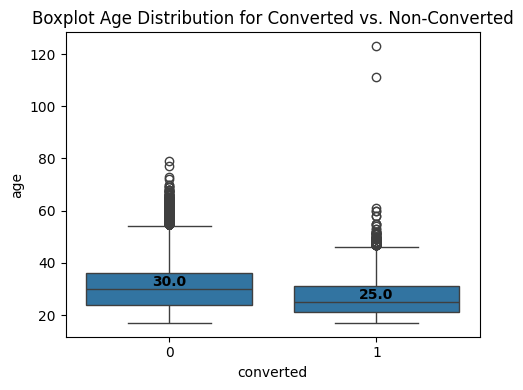

In [20]:
# Boxplot Age Distribution for Converted vs. Non-Converted
plt.figure(figsize=(5, 4))
ax= sns.boxplot(y= age_review['age'], x= age_review['converted'])
medians = age_review.groupby('converted')['age'].median()
for i, median in enumerate(medians):
        ax.text(i, median, f"{median:.1f}", ha='center', va='bottom', color='black', fontsize=10, fontweight='bold')


plt.title('Boxplot Age Distribution for Converted vs. Non-Converted')
plt.tight_layout()
plt.show()

- Based on conversion rate and age distribution, we can see clearly that visitors with a lower age are more likely to convert.

##### Comparison by User Type

In [21]:
# Comparison of Average and Std. Deviation of Page Visits and Conversion by New Users
df_edit.groupby(['new_user'])[['converted']].mean().style.background_gradient().format("{:.2%}")


C:\Users\Tirthankar Raha\AppData\Local\Temp\ipykernel_19044\2903829176.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_edit.groupby(['new_user'])[['converted']].mean().style.background_gradient().format("{:.2%}")


,converted
new_user,
0,7.20%
1,1.40%


In [22]:
df_edit['new_user'].value_counts(normalize= True)* 100

new_user
1    68.54649
0    31.45351
Name: proportion, dtype: float64

- For existing users, we have higher avg. page visits and %age conversion of 7.20%. However, majority of users are new (68.55%), which have a conversion rate of only 1.40%.

##### Comparison by Channel

In [23]:
# Comparison of Average and Std. Deviation of Page Visits and Conversion by Channel
df_edit.groupby(['channel'], observed= True)[['converted']].mean().style.background_gradient().format("{:.2%}")

,converted
channel,
Ads,3.45%
Direct,2.82%
Seo,3.29%


- We observe the highest conversion rate of 3.45% among visitors from ads, which is slightly higher than with SEO.
- Lowest conversion rate is observed among Direct visitors (2.82%).

##### Comparison by Page Visits

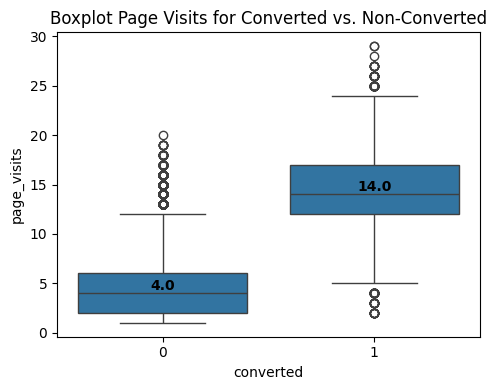

In [24]:
# Boxplot Page Visits for Converted vs. Non-Converted
plt.figure(figsize=(5, 4))
ax= sns.boxplot(y= df_edit['page_visits'], x= df_edit['converted'])
medians = df_edit.groupby('converted')['page_visits'].median()
for i, median in enumerate(medians):
        ax.text(i, median, f"{median:.1f}", ha='center', va='bottom', color='black', fontsize=10, fontweight='bold')


plt.title('Boxplot Page Visits for Converted vs. Non-Converted')
plt.tight_layout()
plt.show()

- Median page visits for converted visitors is 14. Hence, generally users who visit more no. of pages are more likely to convert, as expected.

#### Summary of Observations

1. We have 2 numeric discrete variables (age, total_pages_visited), 2 categorical finite variables (country, source) and 2 categorical boolean variables (new_user, converted)
2. Based on the variables provided, there are likely to be duplicates and it would not be wrong to have them. Hence we are not removing any duplicates. No Null values were found.
3.  Numeric variables age aand total_pages_visited have outliers, age having the most outliers. Two sessions have age > 100, which seems unlikely. The outliers for now haven't been addressed, and would be treated as necessary at the modeling stage.
4. Columns were renamed from total_pages_visited to page_visits and source to channel, for accurate representation and brevity.
5. **Univariate Analysis**:
    - Distribution of numeric variables age and page_visits are both skewed to the right. 
    - Most visitors are aged 30 and visit 4 pages.
    - For our target variable (converted), we have ~3% values as converted. There is a high *Class Imbalance*, and if we might not be getting good prediction from our model, we might consider balancing.
6. **Bivariate Analysis**:
    - *Comparison by Markets*:
        - Germany has the highest conversion ratio (6.25%), whereas China has the least (0.13%). Hence, Germany might be an emerging market, whereas China, given it's higher users and lower conversion rate, shows good potential.
    - *Comparison by Age*:
        - Highest conversion rate of 5.54% is observed in the lower age bracket of 17-24, whereas we have the lowest conversion rate in the very-high age bracket of 37+.
        - Based on conversion rate and age distribution, we can see clearly that visitors with a lower age are more likely to convert.
    - *Comparison by User Type*:
        - For existing users, we have higher avg. page visits and %age conversion of 7.20%. However, majority of users are new (68.55%), which have a conversion rate of only 1.40%.
    - *Comparison by Channel*:
        - We observe the highest conversion rate of 3.45% among visitors from ads, which is slightly higher than with SEO.
        - Lowest conversion rate is observed among Direct visitors (2.82%).
    - *Comparison by Page Visits*:
        - Median page visits for converted visitors is 14. Hence, generally users who visit more no. of pages are more likely to convert, as expected.

### Statistical Testing
We'll follow the workflow below:
- **[Dependancy among categorical variables]: Chi-Square Test for Independence**
    - Does Conversion get impacted by Market
    - Does Conversion get impacted by Marketing Channel
    - Does Conversion get impacted by User Type
- **[Dependancy among numerical and categorical variables]: Independent 2 sample t-test/Mann-Whitney U-test for median**
    - Check normal distribution for age, page_visits
    - Equality of variance for age, page_visits (Levene's Test for equality of variance)
    - Apply suitable hypothesis testing model (2-sample t-test/Mann-Whitney).

In [25]:
df_edit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   country      316200 non-null  category
 1   age          316200 non-null  int64   
 2   new_user     316200 non-null  category
 3   channel      316200 non-null  category
 4   page_visits  316200 non-null  int64   
 5   converted    316200 non-null  int64   
dtypes: category(3), int64(3)
memory usage: 8.1 MB


#### Chi-Square Test for Independence (Stat. Significance)

In [26]:
# Function to conduct Chi-Square Test of Independence
## Alpha for statistical test is being set to 0.05.
def chi_test(data, col1, conv):
    ''' 
    Intended to setup contingency table and conduct Chi-Square test for independence to determine if we can reject the null hypothesis, 
    that the conversion rate is not impacted by the categorical variable. Function returns the p-value as output.
    Arguments:
    data: Name of Dataframe
    col1: categorical variable name
    conv: Column referring to session conversion 
    '''
    cont_table= data.pivot_table(index= col1, columns= conv, aggfunc= 'size', fill_value= 0, observed= True)
    cont_table= cont_table.to_numpy()
    result= chi2_contingency(cont_table, correction= False)[1]
    return result

In [27]:
print('p-value Chi Square Test for Market:', chi_test(df_edit,'country','converted'))
print('p-value Chi Square Test for Channel:', chi_test(df_edit,'channel','converted'))
print('p-value Chi Square Test for User Type:', chi_test(df_edit,'new_user','converted'))

p-value Chi Square Test for Market: 0.0
p-value Chi Square Test for Channel: 1.2160321383469431e-12
p-value Chi Square Test for User Type: 0.0


Based on the p-value of the above tests (< 0.05), we can claim that session conversion is definitely influenced by the Market, Channel and User type.

#### Dependancy among numerical and categorical variables

##### Check normal distribution for age, page_visits

In [28]:
df_edit[df_edit['converted'] == 1].info()

<class 'pandas.core.frame.DataFrame'>
Index: 10200 entries, 54 to 316184
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   country      10200 non-null  category
 1   age          10200 non-null  int64   
 2   new_user     10200 non-null  category
 3   channel      10200 non-null  category
 4   page_visits  10200 non-null  int64   
 5   converted    10200 non-null  int64   
dtypes: category(3), int64(3)
memory usage: 349.1 KB


Given we have 10,200 data points for converted visitors, Shapiro test doesn't give accurate results (The Shapiro-Wilk test is designed for smaller sample sizes and may not give accurate p-values for datasets larger than 5,000 points). We'll go for Anderson test for Normality instead.

In [29]:
# Extract the 'age' values for converted users
data = df_edit[df_edit['converted'] == 1]['age']

# Perform Anderson-Darling test for normality
result = anderson(data, dist='norm')

print(f"Anderson-Darling Statistic: {result.statistic:.4f}")
print("\nSignificance Level (%) | Critical Value | Test Result")
print("-" * 70)
for sl, cv in zip(result.significance_level, result.critical_values):
    test_outcome = "Reject H0 (Not Normal)" if result.statistic > cv else "Fail to Reject H0 (Normal)"
    print(f"{sl:>21}% | {cv:>14.4f} | {test_outcome}")

Anderson-Darling Statistic: 132.4654

Significance Level (%) | Critical Value | Test Result
----------------------------------------------------------------------
                 15.0% |         0.5760 | Reject H0 (Not Normal)
                 10.0% |         0.6560 | Reject H0 (Not Normal)
                  5.0% |         0.7870 | Reject H0 (Not Normal)
                  2.5% |         0.9180 | Reject H0 (Not Normal)
                  1.0% |         1.0920 | Reject H0 (Not Normal)


In [30]:
# Extract the 'age' values for converted users
data = df_edit[df_edit['converted'] == 0]['age']

# Perform Anderson-Darling test for normality
result = anderson(data, dist='norm')

print(f"Anderson-Darling Statistic: {result.statistic:.4f}")
print("\nSignificance Level (%) | Critical Value | Test Result")
print("-" * 70)
for sl, cv in zip(result.significance_level, result.critical_values):
    test_outcome = "Reject H0 (Not Normal)" if result.statistic > cv else "Fail to Reject H0 (Normal)"
    print(f"{sl:>21}% | {cv:>14.4f} | {test_outcome}")

Anderson-Darling Statistic: 1562.2182

Significance Level (%) | Critical Value | Test Result
----------------------------------------------------------------------
                 15.0% |         0.5760 | Reject H0 (Not Normal)
                 10.0% |         0.6560 | Reject H0 (Not Normal)
                  5.0% |         0.7870 | Reject H0 (Not Normal)
                  2.5% |         0.9180 | Reject H0 (Not Normal)
                  1.0% |         1.0920 | Reject H0 (Not Normal)


In [31]:
# Extract the 'page visits' values for converted users
data = df_edit[df_edit['converted'] == 1]['page_visits']

# Perform Anderson-Darling test for normality
result = anderson(data, dist='norm')

print(f"Anderson-Darling Statistic: {result.statistic:.4f}")
print("\nSignificance Level (%) | Critical Value | Test Result")
print("-" * 70)
for sl, cv in zip(result.significance_level, result.critical_values):
    test_outcome = "Reject H0 (Not Normal)" if result.statistic > cv else "Fail to Reject H0 (Normal)"
    print(f"{sl:>21}% | {cv:>14.4f} | {test_outcome}")

Anderson-Darling Statistic: 26.6935

Significance Level (%) | Critical Value | Test Result
----------------------------------------------------------------------
                 15.0% |         0.5760 | Reject H0 (Not Normal)
                 10.0% |         0.6560 | Reject H0 (Not Normal)
                  5.0% |         0.7870 | Reject H0 (Not Normal)
                  2.5% |         0.9180 | Reject H0 (Not Normal)
                  1.0% |         1.0920 | Reject H0 (Not Normal)


In [32]:
# Extract the 'page visits' values for converted users
data = df_edit[df_edit['converted'] == 0]['page_visits']

# Perform Anderson-Darling test for normality
result = anderson(data, dist='norm')

print(f"Anderson-Darling Statistic: {result.statistic:.4f}")
print("\nSignificance Level (%) | Critical Value | Test Result")
print("-" * 70)
for sl, cv in zip(result.significance_level, result.critical_values):
    test_outcome = "Reject H0 (Not Normal)" if result.statistic > cv else "Fail to Reject H0 (Normal)"
    print(f"{sl:>21}% | {cv:>14.4f} | {test_outcome}")

Anderson-Darling Statistic: 5632.7733

Significance Level (%) | Critical Value | Test Result
----------------------------------------------------------------------
                 15.0% |         0.5760 | Reject H0 (Not Normal)
                 10.0% |         0.6560 | Reject H0 (Not Normal)
                  5.0% |         0.7870 | Reject H0 (Not Normal)
                  2.5% |         0.9180 | Reject H0 (Not Normal)
                  1.0% |         1.0920 | Reject H0 (Not Normal)


Based on the above test, the distribution isn't normal for age and page_visits, hence we don't need to conduct Equality of Variance Test. We'll move forward with **Mann-Whitney U-test**.

In [33]:
u_stat_age, u_p_value_age = mannwhitneyu(df_edit[df_edit['converted'] == 1]['age'] , df_edit[df_edit['converted'] == 0]['age'])
u_stat_page_visit, u_p_value_page_visits = mannwhitneyu(df_edit[df_edit['converted'] == 1]['page_visits'] , df_edit[df_edit['converted'] == 0]['page_visits'])

print("P-Value Mann-Whitney U Test for Medians(age):",u_p_value_age)
print("P-Value Mann-Whitney U Test for Medians(page_visits):",u_p_value_page_visits)

P-Value Mann-Whitney U Test for Medians(age): 0.0
P-Value Mann-Whitney U Test for Medians(page_visits): 0.0


Based on the p-values, we can reject the null hypothesis, and conclude that age and page_visits influence conversion significantly. This is also something we observed during EDA.

### Develop Machine Learning Classification Model
We'll follow the workflow below:
- Identify relevant variables for modeling based on Stats Testing.
- Design classification models using:
    - Logistic Regression
    - Naive Bayes
    - Random Forest with Cross Validation
    - XGBoost with Cross Validation
- Model Tuning and EDA




##### Model Building

In [34]:
df_edit.head()

,country,age,new_user,channel,page_visits,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [35]:
# Encoding categorical variables
df_edit = pd.get_dummies(df_edit, columns=['country', 'channel'], drop_first=True)
df_edit.head()

,age,new_user,page_visits,converted,country_Germany,country_UK,country_US,channel_Direct,channel_Seo
0,25,1,1,0,False,True,False,False,False
1,23,1,5,0,False,False,True,False,True
2,28,1,4,0,False,False,True,False,True
3,39,1,5,0,False,False,False,False,True
4,30,1,6,0,False,False,True,False,True


In [36]:
# 1. Train-Test Split

# Features and target variable
X = df_edit.drop('converted', axis=1) #Features
y = df_edit['converted'] #Target

# Split data (30% test, stratified by target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [37]:
# 2. Feature Scaling

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame to preserve column names for interpretation
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

##### Logistic Regression

In [38]:
X_train_scaled.head()

,age,new_user,page_visits,country_Germany,country_UK,country_US,channel_Direct,channel_Seo
143925,0.216981,0.0,0.107143,0.0,0.0,0.0,1.0,0.0
150796,0.198113,1.0,0.178571,0.0,0.0,1.0,0.0,1.0
182781,0.150943,1.0,0.107143,0.0,0.0,1.0,0.0,0.0
125203,0.037736,1.0,0.464286,1.0,0.0,0.0,0.0,1.0
104046,0.103774,1.0,0.214286,0.0,1.0,0.0,1.0,0.0


In [39]:
# 1. Train Logistic Regression

clf = LogisticRegression().fit(X_train_scaled, y_train)
print("Coefficients:", clf.coef_)
print("Intercept:", clf.intercept_)

Coefficients: [[-6.80834339 -1.70236084 20.38482777  3.89898985  3.62156715  3.29029248
  -0.17930416 -0.02954408]]
Intercept: [-10.68692822]


In [40]:
# 2. Predictions on test set
y_pred_lr = clf.predict(X_test_scaled)
y_prob_lr = clf.predict_proba(X_test_scaled)[:, 1]

In [41]:
# Define function for Confusion Matrix
def conf_matrix(model, y_pred):
    '''
    Accepts as argument model object, and y data (predictions). 
    Return a plot of confusion matrix for predictions on y data.
    ''' 

    cm = metrics.confusion_matrix(y_test, y_pred, labels = model.classes_)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=model.classes_)
    disp.plot()
    plt.grid(False)  
    plt.show()

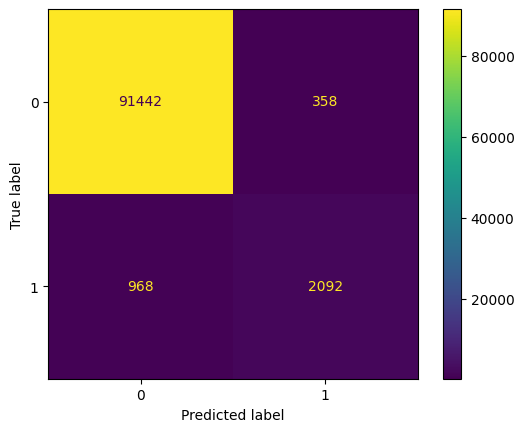

In [42]:
# Plot Confusion Matrix
conf_matrix(clf, y_pred_lr)

In [43]:
# 3. Evaluation metrics
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr, digits=3))

ROC-AUC: 0.9856331076366639

Confusion Matrix:
 [[91442   358]
 [  968  2092]]

Classification Report:
               precision    recall  f1-score   support

           0      0.990     0.996     0.993     91800
           1      0.854     0.684     0.759      3060

    accuracy                          0.986     94860
   macro avg      0.922     0.840     0.876     94860
weighted avg      0.985     0.986     0.985     94860



In [44]:
print('F1 score final LR model: ', round(metrics.f1_score(y_test, y_pred_lr),4))
print('Recall score final LR model: ', round(metrics.recall_score(y_test, y_pred_lr),4))
print('Precision score final LR model: ', round(metrics.precision_score(y_test, y_pred_lr),4))
print('Accuracy score final LR model: ', round(metrics.accuracy_score(y_test, y_pred_lr),4))

F1 score final LR model:  0.7593
Recall score final LR model:  0.6837
Precision score final LR model:  0.8539
Accuracy score final LR model:  0.986


In [45]:
# Define Results table row
result_df = pd.DataFrame(columns= ['Model','ROC_AUC','Accuracy Score','Precision Score','Recall Score','F1 Score'])
def result(model,y_pred,y_prob):
    global result_df
    roc_auc = "{:.4%}".format(roc_auc_score(y_test, y_prob_lr))
    F1 = "{:.4%}".format(round(metrics.f1_score(y_test, y_pred), 4))
    Recall = "{:.4%}".format(round(metrics.recall_score(y_test, y_pred),4))
    Precision = "{:.4%}".format(round(metrics.precision_score(y_test, y_pred),4))
    Accuracy = "{:.4%}".format(round(metrics.accuracy_score(y_test, y_pred),4))

    result_dict = {'Model':model,
                   'ROC_AUC':roc_auc,
                   'Accuracy Score':Accuracy,
                   'Precision Score':Precision,
                   'Recall Score':Recall,
                   'F1 Score':F1
                   }
    new_df = pd.DataFrame([result_dict])
    result_df = pd.concat([result_df, new_df], ignore_index=True)
    return result_df

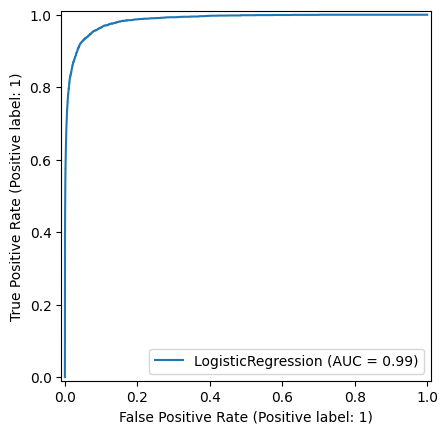

In [46]:
# 4. Plot ROC curve
RocCurveDisplay.from_estimator(clf, X_test_scaled, y_test)
plt.show()

In [47]:
result('LogisticRegression',y_pred_lr,y_prob_lr)

,Model,ROC_AUC,Accuracy Score,Precision Score,Recall Score,F1 Score
0,LogisticRegression,98.5633%,98.6000%,85.3900%,68.3700%,75.9300%


##### Naive Bayes Classification

In [48]:
# 1. Fit the model
gnb = GaussianNB()
gnb.fit(X_train_scaled,y_train)

# 2. Get predictions on test data
y_preds_nb = gnb.predict(X_test_scaled)
y_prob_nb = gnb.predict_proba(X_test_scaled)[:, 1]

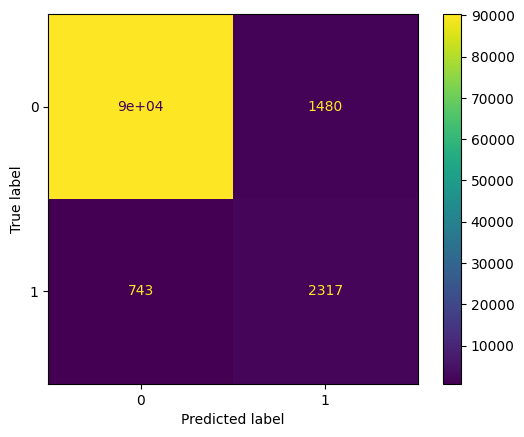

In [49]:
# Plot Confusion Matrix
conf_matrix(gnb, y_preds_nb)

In [50]:
# 3. Evaluation metrics
print("ROC-AUC:", roc_auc_score(y_test, y_prob_nb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_preds_nb))
print("\nClassification Report:\n", classification_report(y_test, y_preds_nb, digits=3))

ROC-AUC: 0.9781570620986232

Confusion Matrix:
 [[90320  1480]
 [  743  2317]]

Classification Report:
               precision    recall  f1-score   support

           0      0.992     0.984     0.988     91800
           1      0.610     0.757     0.676      3060

    accuracy                          0.977     94860
   macro avg      0.801     0.871     0.832     94860
weighted avg      0.980     0.977     0.978     94860



In [51]:
print('F1 score final LR model: ', round(metrics.f1_score(y_test, y_preds_nb),4))
print('Recall score final LR model: ', round(metrics.recall_score(y_test, y_preds_nb),4))
print('Precision score final LR model: ', round(metrics.precision_score(y_test, y_preds_nb),4))
print('Accuracy score final LR model: ', round(metrics.accuracy_score(y_test, y_preds_nb),4))

F1 score final LR model:  0.6758
Recall score final LR model:  0.7572
Precision score final LR model:  0.6102
Accuracy score final LR model:  0.9766


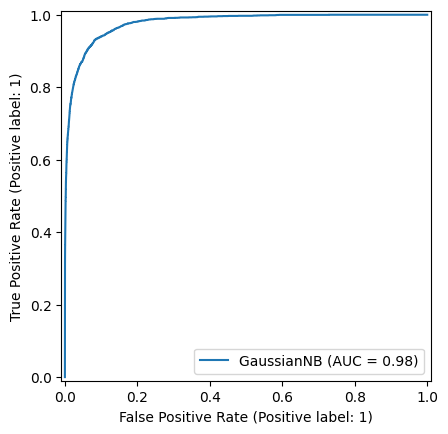

In [52]:
# 4. Plot ROC curve
RocCurveDisplay.from_estimator(gnb, X_test_scaled, y_test)
plt.show()

In [53]:
result('NaiveBayes',y_preds_nb,y_prob_nb)

,Model,ROC_AUC,Accuracy Score,Precision Score,Recall Score,F1 Score
0,LogisticRegression,98.5633%,98.6000%,85.3900%,68.3700%,75.9300%
1,NaiveBayes,98.5633%,97.6600%,61.0200%,75.7200%,67.5800%


##### Random Forest with Cross Validation

In [54]:
# 1. Define parameter grid
cv_params = {
    'n_estimators': [100,120],       # Number of trees
    'max_depth': [5,10],       # Maximum depth of each tree
    'min_samples_split': [10],      # Minimum samples required to split a node
    'min_samples_leaf': [2],       # Minimum samples required at a leaf node
    'max_features': ['log2']  # Number of features considered at each split
}

In [55]:
# 2. Initialize Random Forest
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [56]:
# 3. Grid Search with Cross-Validation
# Using default 5-fold CV here; simpler and avoids PredefinedSplit complexity
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=cv_params,
    scoring='f1',        # Optimize for recall (important for cancelled rides)
    refit=True,
    cv=5,
    verbose=1
)

In [57]:
%%time
# 4. Fit GridSearch on training data
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
CPU times: total: 13min 37s
Wall time: 2min 23s


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [5, 10], 'max_features': ['log2'], 'min_samples_leaf': [2], 'min_samples_split': [10], ...}"
,scoring,'f1'
,n_jobs,None
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,120


In [58]:
# 5. Best parameters & estimator
print("Best Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

Best Parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 120}


In [59]:
# 6. Predictions on test set
y_pred_rf = best_rf.predict(X_test_scaled)
y_prob_rf = best_rf.predict_proba(X_test_scaled)[:, 1]

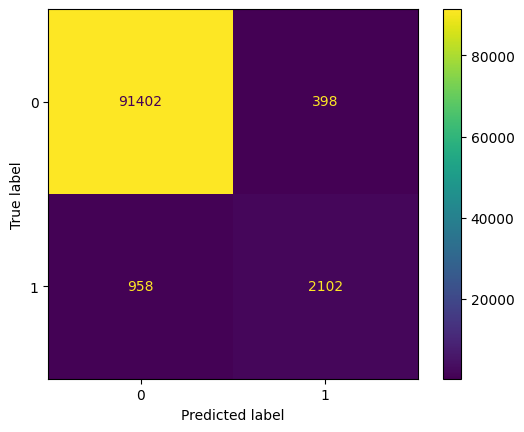

In [60]:
# Plot Confusion Matrix
conf_matrix(grid_search, y_pred_rf)

In [61]:
# 7. Evaluation Metrics
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_rf))

ROC-AUC: 0.9830537239950446

Confusion Matrix:
 [[91402   398]
 [  958  2102]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     91800
           1       0.84      0.69      0.76      3060

    accuracy                           0.99     94860
   macro avg       0.92      0.84      0.87     94860
weighted avg       0.98      0.99      0.99     94860

ROC-AUC Score: 0.9830537239950446


In [62]:
print('F1 score final RF model: ', round(metrics.f1_score(y_test, y_pred_rf),4))
print('Recall score final RF model: ', round(metrics.recall_score(y_test, y_pred_rf),4))
print('Precision score final RF model: ', round(metrics.precision_score(y_test, y_pred_rf),4))
print('Accuracy score final RF model: ', round(metrics.accuracy_score(y_test, y_pred_rf),4))

F1 score final RF model:  0.7561
Recall score final RF model:  0.6869
Precision score final RF model:  0.8408
Accuracy score final RF model:  0.9857


In [63]:
result('RandomForest',y_pred_rf,y_prob_rf)

,Model,ROC_AUC,Accuracy Score,Precision Score,Recall Score,F1 Score
0,LogisticRegression,98.5633%,98.6000%,85.3900%,68.3700%,75.9300%
1,NaiveBayes,98.5633%,97.6600%,61.0200%,75.7200%,67.5800%
2,RandomForest,98.5633%,98.5700%,84.0800%,68.6900%,75.6100%


In [64]:
# result_df= result_df.drop(2)
# result_df.head()

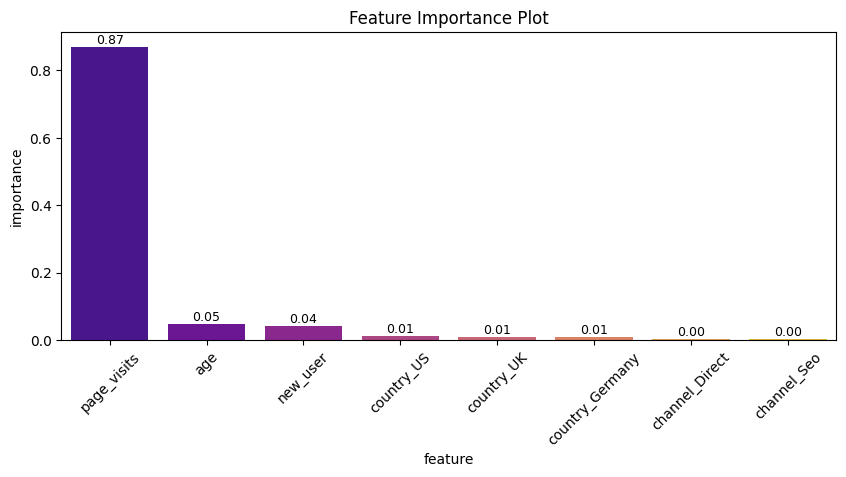

In [65]:
# 9. Feature Importance (top 10)
plt.figure(figsize=(10,4))
importances = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': best_rf.feature_importances_
}).sort_values(by='importance', ascending=False).head(10).reset_index(drop= True)

ax = sns.barplot(data= importances, x= 'feature', y= 'importance', hue='feature', palette= 'plasma')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height, f'{height:.2f}', 
            ha='center', va='bottom', fontsize=9)

plt.xticks(rotation= 45)
plt.title('Feature Importance Plot')
plt.show()

##### XGBoost

In [75]:
# 1. Initialize XGBoost & fit on training data

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',        # ROC-AUC evaluation
    scale_pos_weight=13.29,   # adjust based on class imbalance
    random_state=42,
    n_jobs=-1
)


In [108]:
# Setting parameters & scoring for grid search
cv_params = {
    'max_depth': [3],
    'min_child_weight': [1],
    'learning_rate': [0.3,0.4],
    'n_estimators': [150,160,170],
    }

scoring= ['accuracy','precision','recall','f1']

In [109]:
# Initiate Grid Search 
xgb_cv= GridSearchCV(xgb, cv_params, scoring= scoring, cv = 5, refit= 'f1')

In [110]:
%%time
xgb_cv.fit(X_train_scaled, y_train)

CPU times: total: 3min
Wall time: 34.8 s


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'learning_rate': [0.3, 0.4], 'max_depth': [3], 'min_child_weight': [1], 'n_estimators': [150, 160, ...]}"
,scoring,"['accuracy', 'precision', ...]"
,n_jobs,None
,refit,'f1'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [111]:
# 2. Best parameters & estimator
print("Best Parameters:", xgb_cv.best_params_)
best_xgb = xgb_cv.best_estimator_

Best Parameters: {'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 160}


In [112]:
# 3. Predictions & evaluate performance
y_pred_xgb = xgb_cv.predict(X_test_scaled)
y_prob_xgb = xgb_cv.predict_proba(X_test_scaled)[:, 1]  # probability for positive class

print("🎯 ROC AUC Score:", metrics.roc_auc_score(y_test, y_prob_xgb))
print("\n📋 Classification Report:\n", metrics.classification_report(y_test, y_pred_xgb, digits=3))
print("Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_pred_xgb))

🎯 ROC AUC Score: 0.9852286460335768

📋 Classification Report:
               precision    recall  f1-score   support

           0      0.996     0.967     0.982     91800
           1      0.475     0.891     0.620      3060

    accuracy                          0.965     94860
   macro avg      0.736     0.929     0.801     94860
weighted avg      0.979     0.965     0.970     94860

Confusion Matrix:
 [[88787  3013]
 [  334  2726]]


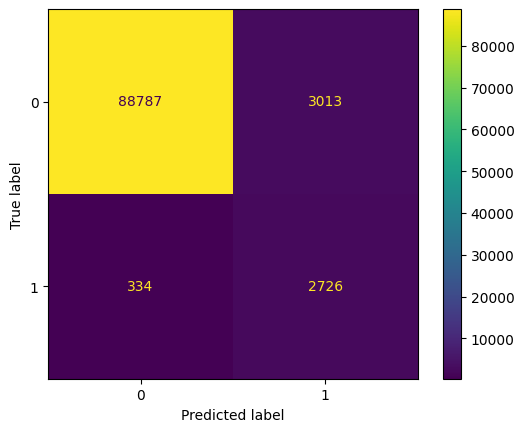

In [113]:
# Plot Confusion Matrix
conf_matrix(xgb_cv, y_pred_xgb)

In [114]:
print('F1 score final XGB model: ', round(metrics.f1_score(y_test, y_pred_xgb),4))
print('Recall score final XGB model: ', round(metrics.recall_score(y_test, y_pred_xgb),4))
print('Precision score final XGB model: ', round(metrics.precision_score(y_test, y_pred_xgb),4))
print('Accuracy score final XGB model: ', round(metrics.accuracy_score(y_test, y_pred_xgb),4))

F1 score final XGB model:  0.6196
Recall score final XGB model:  0.8908
Precision score final XGB model:  0.475
Accuracy score final XGB model:  0.9647


<Figure size 1000x600 with 0 Axes>

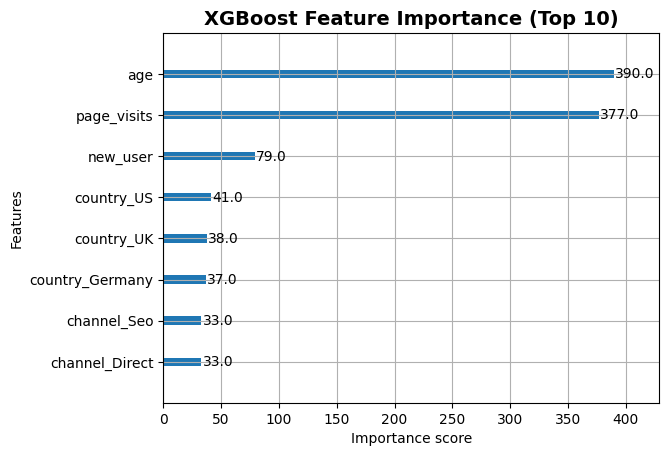

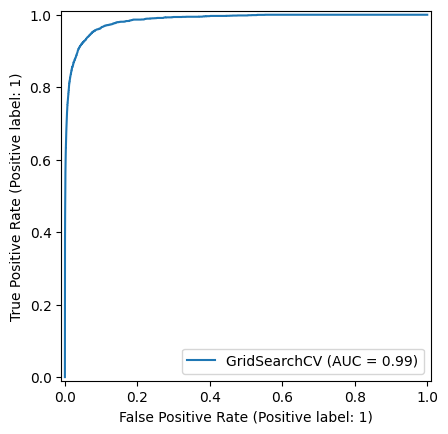

In [115]:
# 4. Feature Importance & ROC Curve
plt.figure(figsize=(10,6))
plot_importance(xgb_cv.best_estimator_, max_num_features=10)
plt.title("XGBoost Feature Importance (Top 10)", fontsize=14, weight='bold')
plt.show()

RocCurveDisplay.from_estimator(xgb_cv, X_test_scaled, y_test)
plt.show()

In [117]:
result('XGBoost',y_pred_xgb,y_prob_xgb)

,Model,ROC_AUC,Accuracy Score,Precision Score,Recall Score,F1 Score
0,LogisticRegression,98.5633%,98.6000%,85.3900%,68.3700%,75.9300%
1,NaiveBayes,98.5633%,97.6600%,61.0200%,75.7200%,67.5800%
2,RandomForest,98.5633%,98.5700%,84.0800%,68.6900%,75.6100%
3,XGBoost,98.5633%,96.4700%,47.5000%,89.0800%,61.9600%


### Final Assessment, Summary and Recommendations